# Comparison

We run an experiment to calculate the learning curves for the methods and measure the performance using the root mean-squared (RMS) error between the value function learned and the true value function, averaged over the five states, then averaged over 100 runs.

The hyperparameter alpha.

In [34]:
import numpy as np

def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

We ran the experiment on the Random Walk (RW) environment using the "all-left" policy

In [35]:
class Space:
    def __init__(self, value):
        self.n = value 
    
class RandomWalk:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = Space(7)
        self._state = np.random.choice([1,2,3,4,5])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')
        self._state += np.random.choice([-1, 1])
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 5: self._done = True; reward = 1
        return self._state, reward, self._done, 0  # obs, rew, done

In [36]:
env = RandomWalk()

In [37]:
def pi(state):
    return 1

MC:

In [38]:
from itertools import count

def generate_trajectory(pi, env, max_steps=200):
    done, trajectory = False, []
    while not done:
        state = env.reset()
        for t in count():
            action = pi(state) 
            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    return np.array(trajectory, object)

In [39]:
def mc(pi, env, gamma=1.0,
       init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
       n_episodes=500, max_steps=200):
    nS = env.observation_space.n
    discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False)
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    for e in range(n_episodes):
        trajectory = generate_trajectory(pi, env, max_steps)
        visited = np.zeros(nS, dtype=bool)
        for t, (state, _, reward, _, _) in enumerate(trajectory):
            if visited[state]: continue
            visited[state] = True
            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            V[state] = V[state] + alphas[e] * (G - V[state])
            V_track[e] = V
    return V.copy(), V_track

TD:

In [40]:
def td(pi, env, gamma=1.0, 
       init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
       n_episodes=500):
    nS = env.observation_space.n
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    for e in range(n_episodes):
        state, done = env.reset(), False
        while not done:
            action = pi(state)
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * V[next_state] * (not done)
            td_error = td_target - V[state]
            V[state] = V[state] + alphas[e] * td_error
            state = next_state
        V_track[e] = V
    return V, V_track

n-step TD:

In [41]:
def generate_path(pi, env, state, n_steps):
    path = []
    done = False
    while len(path) < n_steps:
        action = pi(state) 
        next_state, reward, done, _ = env.step(action)
        experience = (state, action, reward, next_state, done)
        path.append(experience)
        if done: 
            break
        state = next_state
    return np.array(path, object)

In [46]:
def ntd(pi, env, gamma=1.0,
        init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
        n_steps=3, n_episodes=500):
    nS = env.observation_space.n
    discounts = np.logspace(0, n_steps+1, num=n_steps+1, base=gamma, endpoint=False)
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64) 
    for e in range(n_episodes):
        state, done = env.reset(), False
        while not done:
            path = generate_path(pi, env, state, n_steps) 
            n = len(path)
            visited = np.zeros(nS, dtype=bool)
            for t, (path_state, _, reward, path_next_state, path_done) in enumerate(path):                
                partial_return = np.sum(discounts[:n-t] * path[t:, 2])
                ntd_target = partial_return + discounts[n] * V[path[n-1, 3]]  * (not path_done)
                ntd_error = ntd_target - V[path_state]
                V[path_state] = V[path_state] + alphas[e] * ntd_error                   
                state = path_next_state
                done = path_done
        V_track[e] = V
    return V.copy(), V_track

TD-lambda:

In [47]:
def td_lambda(pi, env, gamma=1.0,
              init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
              lambda_=0.2, n_episodes=500):
    nS = env.observation_space.n
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    E = np.zeros(nS, dtype=np.float64)
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    for e in range(n_episodes):
        E.fill(0)
        state, done = env.reset(), False
        while not done:
            action = pi(state)
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * V[next_state] * (not done)
            td_error = td_target - V[state]
            E[state] = E[state] + 1
            V = V + alphas[e] * td_error * E
            E = gamma * lambda_ * E
            state = next_state
        V_track[e] = V
    return V, V_track

Experiment:

In [48]:
from collections import defaultdict

def run_experiment(algorithm, nb_runs, env, pi,):
    V_init = defaultdict(lambda: 0.5)   # init V to 0.5
    V_init[0] = V_init[6] = 0.0         # but terminal states to zero !!

    V_runs = []
    for i in range(nb_runs):
        _, V_td_track = algorithm(pi,env)
        V_runs.append(V_td_track)
    V_runs = np.array(V_runs) 
    
    V_runs = V_runs[:,:,1:-1]  # remove data about terminal states (which is always zero anyway)
    error_to_true = V_runs - env.V_true[1:-1]
    squared_error = np.power(error_to_true, 2)
    mean_squared_error = np.average(squared_error, axis=-1)  # avg over states
    root_mean_squared_error = np.sqrt(mean_squared_error)
    rmse_avg_over_runs = np.average(root_mean_squared_error, axis=0)
    
    return rmse_avg_over_runs  # this is data that goes directly on the plot

In [49]:
rmse_mc = run_experiment(mc, 100, env, pi)
rmse_td = run_experiment(td, 100, env, pi)
rmse_ntd = run_experiment(ntd, 100, env, pi)
rmse_td_lamda = run_experiment(td_lambda, 100, env, pi)

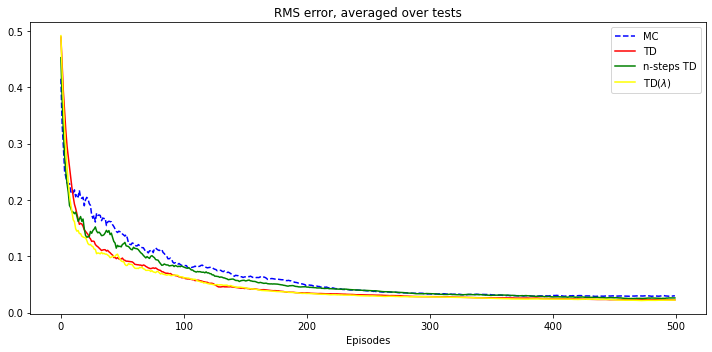

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(rmse_mc, color='blue', linestyle='--', label='MC')
plt.plot(rmse_td, color='red', linestyle='-', label='TD')
plt.plot(rmse_ntd, color='green', linestyle='-', label='n-steps TD')
plt.plot(rmse_td_lamda, color='yellow', linestyle='-', label='TD($\lambda$)')
plt.title('RMS error, averaged over tests')
plt.xlabel('Episodes')
plt.legend()
plt.tight_layout()
plt.show()